In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
     #   print(os.path.join(dirname, filename))
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/cell-images-for-detecting-malaria
/kaggle/input/cell-images-for-detecting-malaria/cell_images
/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected
/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected


## Import necessary libraries

In [3]:
import matplotlib.pyplot as plt
import keras, shutil
from keras.layers import Input, MaxPooling2D, AveragePooling2D, Conv2D, Dense, Flatten, concatenate, BatchNormalization, Add, ZeroPadding2D, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

## Load Data

In [4]:
path = '/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/'

# print number of samples in each class
print("Parasitized samples: ", len(os.listdir(os.path.join(path, 'Parasitized'))))
print("Uninfected samples: ", len(os.listdir(os.path.join(path, 'Uninfected'))))

Parasitized samples:  13780
Uninfected samples:  13780


There are total 27560 samples in our data. I will use 20% of the data for the validation set. which means that, 2712 images from each class will be moved to validation directory.

In [6]:
temp_path = '/kaggle/temp/'
os.mkdir(temp_path)

# create 'train' and 'val' directory
# also create sub directories within each directory named as 'parasitized' and 'uninfected' 
os.mkdir(os.path.join(temp_path, 'train'))
os.mkdir(os.path.join(temp_path, 'train/parasitized'))
os.mkdir(os.path.join(temp_path, 'train/uninfected'))

os.mkdir(os.path.join(temp_path, 'val'))
os.mkdir(os.path.join(temp_path, 'val/parasitized'))
os.mkdir(os.path.join(temp_path, 'val/uninfected'))

First we will copy all images from '/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images' to '/kaggle/temp/train/' and then we will move 20% images to 'val' directory.

In [7]:
# copy images to 'train' and 'val' directories in '/kaggle/temp'

# copy all images to 'train' directory
for filename in os.listdir(os.path.join(path, 'Parasitized')):
    src = path + 'Parasitized/' + filename
    dst = temp_path + 'train/parasitized'
    shutil.copy(src, dst)
    
for filename in os.listdir(os.path.join(path, 'Uninfected')):
    src = path + 'Uninfected/' + filename
    dst = temp_path + 'train/uninfected'
    shutil.copy(src, dst)
    
# move 20% of the images to 'val' directory
for filename in os.listdir(os.path.join(temp_path, 'train/parasitized'))[0:2712]:
    src = temp_path + 'train/parasitized/' + filename
    dst = temp_path + 'val/parasitized'
    shutil.move(src, dst)
    
for filename in os.listdir(os.path.join(temp_path, 'train/uninfected'))[0:2712]:
    src = temp_path + 'train/uninfected/' + filename
    dst = temp_path + 'val/uninfected'
    shutil.move(src, dst)

In [8]:
# print number of samples in 'train' and 'val' directory
train_num_samples = 0
for _, _, filenames in os.walk(os.path.join(temp_path, 'train')):
    train_num_samples += len(filenames)
    
val_num_samples = 0
for _, _, filenames in os.walk(os.path.join(temp_path, 'val')):
    val_num_samples += len(filenames)
    
print("train_num_samples: ",train_num_samples)
print("val_num_samples: ",val_num_samples)

train_num_samples:  22136
val_num_samples:  5424


In [16]:
# create Image Data Generator
datagen = ImageDataGenerator(rescale = 1.0 / 255)

train_batch_size = 32
train_dir = temp_path + 'train/'

# create train image generator
train_gen = datagen.flow_from_directory(train_dir,
                                       target_size = (224,224),
                                       batch_size = train_batch_size,
                                       class_mode = 'binary')

# create val image generator
val_batch_size = 32
val_dir = temp_path + 'val'

val_gen = datagen.flow_from_directory(val_dir,
                                     target_size = (224, 224),
                                     batch_size = val_batch_size,
                                     class_mode = 'binary')

Found 22136 images belonging to 2 classes.
Found 5422 images belonging to 2 classes.


In [10]:
# print label encodings
print(train_gen.class_indices)

{'parasitized': 0, 'uninfected': 1}


### Visualize images generated by the ImageGenerator

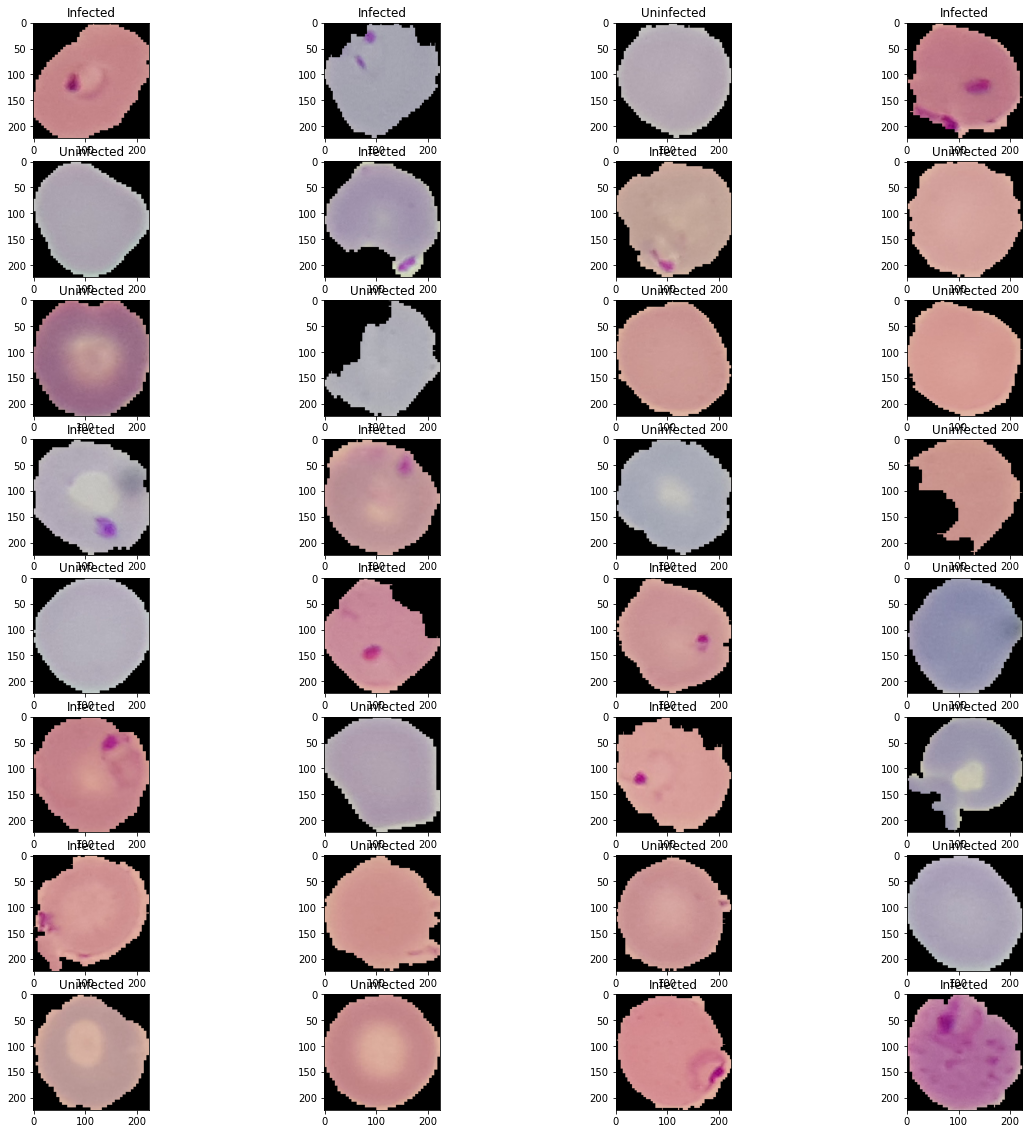

In [11]:
x, y = train_gen.next()

plt.figure(figsize=(20,20))

for i, (img, label) in enumerate(zip(x, y)):
    
    plt.subplot(8, 4, i+1)
    
    if label == 0:
        plt.title('Infected')
    else:
        plt.title('Uninfected')
        
    plt.imshow(img)

## Create InceptionNet (GoogleNet)

In [12]:
def inception_module(X, filters, name=None):
    """
    Creates inception module
    
    Arguments:
    
    X -- input tensor of shape (m , n_H, n_W, n_C)
    filters -- python list, containing number of filters for layers as follows:
                            - conv_1x1         (as f1)
                            - conv_3x3_reduce  (as f2)
                            - conv_3x3         (as f3)
                            - conv_5x5_reduce  (as f4)
                            - conv_5x5         (as f5)
                            - max_pool_reduce  (as f6)
    name -- name of the inception module
    Returns:
    X -- output of the inception module, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve number of filters
    f1, f2, f3, f4, f5, f6 = filters
    
    conv_1x1 = Conv2D(filters = f1, kernel_size = (1,1), strides = (1,1), padding='same', activation='relu', name=name + '/1x1', kernel_regularizer = l2(0.0002))(X)
    
    conv_3x3_reduce = Conv2D(filters = f2, kernel_size = (1,1), strides = (1,1), padding='same', activation='relu', name=name + '/3x3_reduce', kernel_regularizer = l2(0.0002))(X)
    conv_3x3 =        Conv2D(filters = f3, kernel_size = (3,3), strides = (1,1), padding='same',activation='relu', name=name + '/3x3', kernel_regularizer = l2(0.0002))(conv_3x3_reduce)
    
    conv_5x5_reduce = Conv2D(filters = f4, kernel_size = (1,1), strides = (1,1), padding='same', activation='relu', name=name + '/5x5_reduce', kernel_regularizer = l2(0.0002))(X)
    conv_5x5 =        Conv2D(filters = f5, kernel_size = (5,5), strides = (1,1), padding='same', name=name + '5x5', kernel_regularizer = l2(0.0002))(conv_5x5_reduce)
    
    max_pool_reduce = MaxPooling2D(pool_size = (3,3), strides = (1,1), padding='same', name=name + '/pool')(X)
    max_pool = Conv2D(filters = f6, kernel_size = (1,1), strides = (1,1), padding='same', activation='relu', name=name + '/pool_proj', kernel_regularizer = l2(0.0002))(max_pool_reduce)
    
    X = concatenate([conv_1x1, conv_3x3, conv_5x5, max_pool], axis=-1, name=name )
    
    return X

In [19]:
X_input = Input(shape=(224, 224, 3), name='input')

input_pad = ZeroPadding2D(padding=(3,3), name='zero_padding')(X_input)
X = Conv2D(filters = 64, kernel_size = (7,7), strides = (2,2), padding='valid', activation='relu', name='conv_1/7x7', kernel_regularizer = l2(0.0002))(input_pad)

X = Conv2D(filters = 128, kernel_size = (5,5), strides = (2,2), padding='valid', activation='relu', name='conv_2/5x5', kernel_regularizer = l2(0.0002))(X)
X = MaxPooling2D(pool_size = (2,2), strides = (2,2), name='max_pool_1')(X)

X = inception_module(X, filters = [64, 96,128, 16, 32, 32], name='inception_3a')
X = inception_module(X, filters = [128, 128,192, 32,96, 64], name='inception_3b')

X = AveragePooling2D(pool_size = (7,7), strides = (1,1), name='avg_pool_7x7')(X)

X_flatten = Flatten()(X)
X = Dense(units =1024, activation='relu',name='fc_1')(X_flatten)
fc_1_dropout = Dropout(rate=0.3)(X)

X = Dense(1, activation='sigmoid', name='output_layer')(fc_1_dropout)


model = keras.Model(inputs = X_input, outputs = X, name='GoogleNet')
model.summary()

Model: "GoogleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding (ZeroPadding2D)    (None, 230, 230, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv_1/7x7 (Conv2D)             (None, 112, 112, 64) 9472        zero_padding[0][0]               
__________________________________________________________________________________________________
conv_2/5x5 (Conv2D)             (None, 54, 54, 128)  204928      conv_1/7x7[0][0]                 
__________________________________________________________________________________________

### Compile, Train and Evaluate the model

In [27]:
# learning rate decay
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.00003,
                                                        decay_steps = 1000, 
                                                        decay_rate = 0.3)

# compile the model
model.compile(loss='binary_crossentropy',
             optimizer = Adam(learning_rate = 0.00003),
             metrics = ['accuracy'])

# calculate train steps and val steps
train_steps = np.ceil(train_num_samples / train_batch_size)
val_steps = np.ceil(val_num_samples / val_batch_size)

# train the model
history = model.fit_generator(train_gen,
                             steps_per_epoch = train_steps,
                             epochs = 10,
                             validation_data = val_gen,
                             validation_steps = val_steps)

692/692 [==============================] - 69s 100ms/step - loss: 0.2327 - accuracy: 0.9632 - val_loss: 0.2438 - val_accuracy: 0.9609


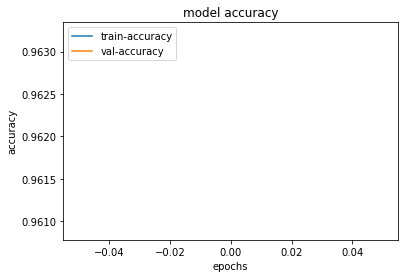

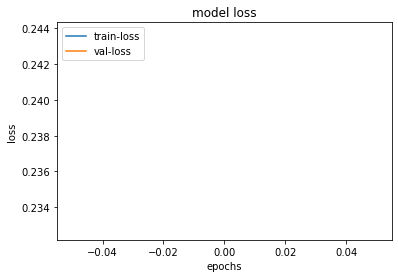

In [28]:
# save the model
model.save("/kaggle/working/malaria_detection.h5")

 
# plot training and validation accuracy
plt.plot(history.history['accuracy'], label='train-accuracy')
plt.plot(history.history['val_accuracy'], label='val-accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='val-loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.show()

In [24]:
model = keras.models.load_model("/kaggle/working/malaria_detection.h5")